In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
numpyro.set_host_device_count(10)

import arviz as az
import seaborn as sns
import daft
from corner import corner

rng = random.PRNGKey(2023)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Suppose we have a cluster of $N$ stars each with distance $d_i$. The cluster will have a mean distance and spread $\mu_d$, $\sigma_d$. We also have apparent magnitudes $m_i$. This is a simplified version of Leistedt and Hogg (2017).

In [2]:
rng, *key = random.split(rng, 5)

num_obs = 320
mu_d = 10
sigma_d = 0.1

shape = (num_obs,)

d = mu_d + sigma_d * random.normal(key[0], shape=shape)
abs_mag = random.normal(key[1], shape=shape)
mag = abs_mag + 5 * np.log10(d)
par = 1 / d

sigma_mag = 0.1
sigma_par = 0.01

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
par_obs = par + sigma_par * random.normal(key[3], shape=shape)

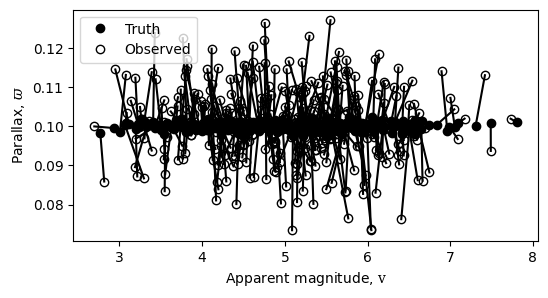

In [3]:
with plt.rc_context({"mathtext.fontset": "dejavuserif"}):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(mag, par, "ok", label="Truth")
    ax.plot(mag_obs, par_obs, "ok", markerfacecolor="none", label="Observed")
    ax.plot(np.stack([mag, mag_obs]), np.stack([par, par_obs]), "k")
#     ax.errorbar(2.1, 0.085, xerr=sigma_mag, yerr=sigma_par, color="k", capsize=4)

    ax.set_xlabel(r"Apparent magnitude, $\mathrm{v}$")
    ax.set_ylabel(r"Parallax, $\varpi$")
    ax.legend(loc="upper left")

In [23]:
def hierarchical_model(num_obs, par_obs=None, mag_obs=None):
    shape = (num_obs,)
    mu_d = numpyro.sample("mu_d", dist.Uniform(0., 20.))
    sigma_d = numpyro.sample("sigma_d", dist.LogNormal(jnp.log(0.1), 1.0))
    _d = numpyro.sample("_d", dist.Normal(), sample_shape=shape)
    d = numpyro.deterministic("d", mu_d + sigma_d * _d)
    
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [24]:
dims = {
    "_d": ["Star"],
    "d": ["Star"], 
    "mag": ["Star"], 
    "abs_mag": ["Star"], 
    "par": ["Star"],
    "par_obs": ["Star"],
    "mag_obs": ["Star"]
}


In [25]:
sampler = NUTS(hierarchical_model, target_accept_prob=0.98)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [26]:
data = {}
for n in [20, 80, 320]:
    coords = {"Star": np.arange(n)}
    rng, key = random.split(rng)
    mcmc.run(key, n, par_obs=par_obs[:n], mag_obs=mag_obs[:n])
    data[n] = az.from_numpyro(mcmc, coords=coords, dims=dims)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [27]:
nstars = r"$N_\mathrm{stars}$"
df = pd.concat(
    {k: v.posterior.to_dataframe() for k, v in data.items()},
    names=[nstars]
).reset_index()
df.head()

,$N_\mathrm{stars}$,chain,draw,Star,_d,abs_mag,d,mag,mu_d,par,sigma_d
0,20,0,0,0,0.214960,-0.617753,9.842375,4.347746,9.832353,0.101601,0.046623
1,20,0,0,1,-0.977430,0.154861,9.786782,5.108060,9.832353,0.102179,0.046623
2,20,0,0,2,-1.244853,-0.450912,9.774314,4.499519,9.832353,0.102309,0.046623
3,20,0,0,3,2.051243,1.265680,9.927987,6.249986,9.832353,0.100725,0.046623
4,20,0,0,4,0.398686,0.003084,9.850941,4.970472,9.832353,0.101513,0.046623


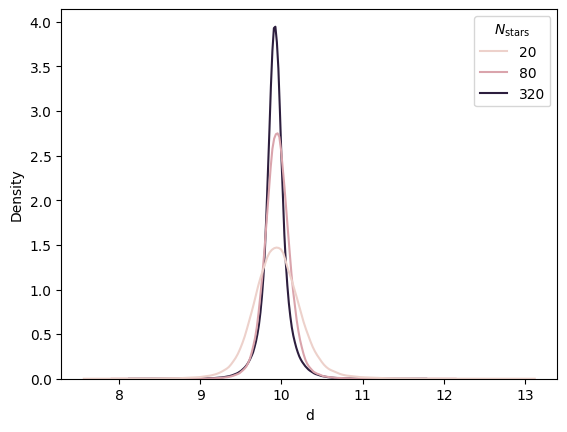

In [40]:
num_samples = 100000
ax = sns.kdeplot(df, x="d", hue=nstars, common_norm=False)

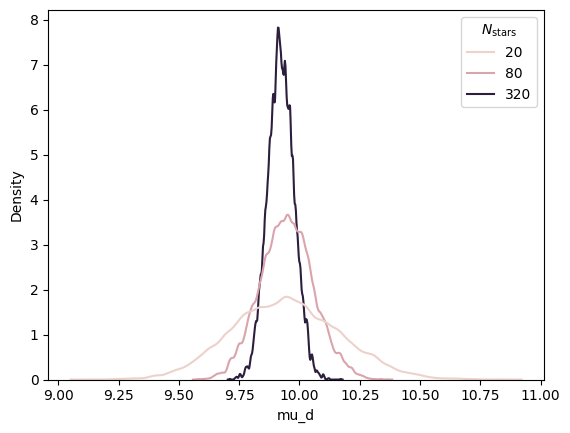

In [50]:
ax = sns.kdeplot(df, x="mu_d", hue=nstars, common_norm=False)

In [48]:
df.groupby(nstars).mean()

,chain,draw,Star,_d,abs_mag,d,mag,mu_d,par,sigma_d
$N_\mathrm{stars}$,,,,,,,,,,
20,4.5,499.5,9.5,0.000392,-0.049452,9.944766,4.937466,9.944353,0.100653,0.162941
80,4.5,499.5,39.5,0.000655,-0.034118,9.947747,4.954192,9.947950,0.100554,0.103146
320,4.5,499.5,159.5,-0.000099,0.032642,9.922764,5.015546,9.922812,0.100802,0.114207


In [49]:
df.groupby(nstars).std()

,chain,draw,Star,_d,abs_mag,d,mag,mu_d,par,sigma_d
$N_\mathrm{stars}$,,,,,,,,,,
20,2.872289,288.675712,5.766296,0.997925,0.798078,0.310257,0.794759,0.224717,0.003142,0.162895
80,2.872283,288.675171,23.092221,0.998201,0.881033,0.169297,0.880268,0.109989,0.001711,0.081642
320,2.872282,288.675035,92.375606,1.000964,0.968275,0.153236,0.967992,0.054869,0.001558,0.087460


In [52]:
df.groupby(nstars).quantile([.16, .5, .84])

chain    draw   Star        _d   abs_mag          d  \
$N_\mathrm{stars}$                                                             
20                 0.16    1.0  159.84    3.0 -0.990989 -0.730943   9.671323   
                   0.50    4.5  499.50    9.5 -0.002877 -0.185484   9.938814   
                   0.84    8.0  839.16   16.0  0.993335  0.996358  10.217010   
80                 0.16    1.0  159.84   12.0 -0.991830 -0.873595   9.799434   
                   0.50    4.5  499.50   39.5  0.000040 -0.081682   9.945427   
                   0.84    8.0  839.16   67.0  0.993894  0.911293  10.095979   
320                0.16    1.0  159.84   51.0 -0.996535 -0.976561   9.810465   
                   0.50    4.5  499.50  159.5 -0.000199  0.093957   9.920982   
                   0.84    8.0  839.16  268.0  0.996413  1.028135  10.034822   

                              mag       mu_d       par   sigma_d  
$N_\mathrm{stars}$                                                
20                 0.16  4.273196   9.722168  0.097876  0.038724  
                   0.50  4.801432   9.940620  0.100616  0.107033  
                   0.84  5.990186  10.168519  0.103398  0.291251  
80                 0.16  4.114808   9.837985  0.099049  0.033009  
                   0.50  4.906451   9.947441  0.100549  0.079389  
                   0.84  5.898684  10.055251  0.102047  0.175191  
320                0.16  4.006405   9.868689  0.099653  0.034597  
                   0.50  5.078576   9.921858  0.100796  0.088461  
                   0.84  6.012926   9.976665  0.101932  0.204309

See how the std for mu_d goes down by 1/2 then 1/2 again by the others don't quite. Likely due to limitations of observables.

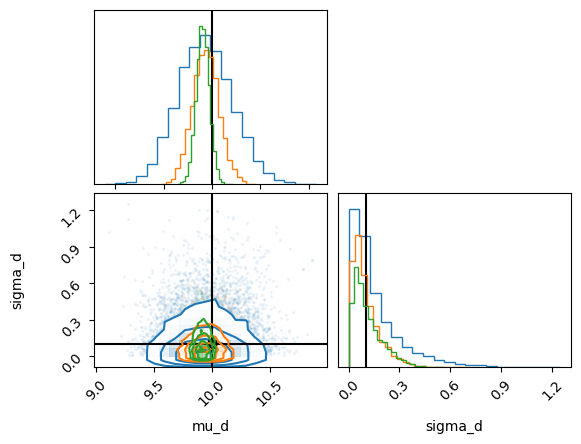

In [36]:
fig = plt.figure()

for i, (k, v) in enumerate(data.items()):
    fig = corner(
        v, 
        var_names=["mu_d", "sigma_d"], 
        truths={"mu_d": mu_d, "sigma_d": sigma_d} if i == 0 else None,
        truth_color="k",
        color=f"C{i}",
        fig=fig,
    )